In [3]:
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

In [4]:
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")
links = pd.read_csv("data/links.csv")
tags = pd.read_csv("data/tags.csv")

First of all let's see what our data is

In [17]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [19]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [20]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# EDA (Semenov Dmitry)

In [5]:
movies.shape

(9742, 3)

In [6]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Check types:

In [7]:
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

No data gaps:

In [8]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [9]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
movieId    9742 non-null int64
title      9742 non-null object
genres     9742 non-null object
dtypes: int64(1), object(2)
memory usage: 228.4+ KB


Let's count genres number:

In [10]:
from nltk import regexp_tokenize

def extract_genres(i=-1):
    if i != -1:
        l = []
        g = movies.iloc[i]['genres']
        for token in regexp_tokenize(g, pattern=r"[|]", gaps=True):
            l.append(token)
        return l
    
    s = set()
    for i in range(movies.shape[0]):
        g = movies.iloc[i]['genres']
        for token in regexp_tokenize(g, pattern=r"[|]", gaps=True):
            s.add(token)
    return [g for g in s]

In [11]:
genresList = extract_genres()
print(str(len(genresList)) + " genres total:")
for genre in genresList: print(genre)

20 genres total:
Mystery
War
Animation
(no genres listed)
IMAX
Adventure
Western
Horror
Film-Noir
Thriller
Children
Documentary
Comedy
Action
Sci-Fi
Romance
Crime
Fantasy
Drama
Musical


How it clearly can be seen there are some movies without any genres 
specified. Let's count number of such a movies:

In [12]:
genresList.remove("(no genres listed)")
counter = 0
for i in range(movies.shape[0]):
    if movies.iloc[i]['genres'] == "(no genres listed)": counter += 1
print ("Total " + str(counter) + " of " + str(movies.shape[0]) + " " +
    str(counter / movies.shape[0]) + "%" + " movies without any genre specified")

Total 34 of 9742 0.0034900431122972695% movies without any genre specified


It's very uncomfortable to use information about genres in the form 
in which it is for analysis. So, let's create another data frame and 
move all this information there. 

In [13]:
genres = pd.DataFrame()
l = []
for i in range(movies.shape[0]):
    l1 = [i + 1]
    for g in genresList:
        
        if g in extract_genres(i): l1.append(1)
        else: l1.append(0)
    l.append(l1)
    
genres=pd.DataFrame(l, columns=["movieId"] + genresList)

In [14]:
genres.head(5)

,movieId,Mystery,War,Animation,IMAX,Adventure,Western,Horror,Film-Noir,Thriller,Children,Documentary,Comedy,Action,Sci-Fi,Romance,Crime,Fantasy,Drama,Musical
0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0
1,2,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
4,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


Now we can easily, for example, count genres to define popularity of different genres:

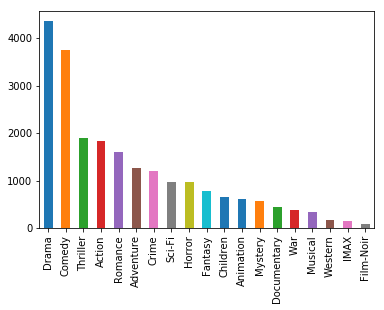

In [47]:
genreSum = genres.drop("movieId", axis=1).sum(axis=0).sort_values(ascending=False)
genreSum.plot(kind='bar')

According to this we can say that most of all people like to cry and laugh :)

# Content-based (Savchenko Alexander)

In [147]:
# create a table with information about movies
movie_info = pd.DataFrame()
movie_info['movieId'] = movies.movieId
movie_info['Key_words'] = ''
movie_info.head()

,movieId,Key_words
0,1,
1,2,
2,3,
3,4,
4,5,


In [148]:
# заполняем информацию о каждом фильме, о фильме мы знаем жанр и тег.
for i in range(0, len(movies)):
    film_info = extract_genres(i)
    film_info.extend(tag for tag in tags[tags.movieId == movies.movieId[i]].tag)
    movie_info.Key_words.iloc[i] = ' '.join(str(item) for item in film_info)
     
movie_info.head()

C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,movieId,Key_words
0,1,Adventure Animation Children Comedy Fantasy pi...
1,2,Adventure Children Fantasy fantasy magic board...
2,3,Comedy Romance moldy old
3,4,Comedy Drama Romance
4,5,Comedy pregnancy remake


In [149]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [150]:
count = CountVectorizer()
count_matrix = count.fit_transform(movie_info['Key_words'])

# generating the cosine similarity matrix
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [186]:
cosine_sim

array([[ 1.        ,  0.3380617 ,  0.15811388, ...,  0.        ,
         0.2236068 ,  0.31622777],
       [ 0.3380617 ,  1.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15811388,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.5       ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.2236068 ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.31622777,  0.        ,  0.5       , ...,  0.        ,
         0.        ,  1.        ]])

In [204]:
#  defining the function that takes in movie title 
# as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):
    
    recommended_movies = []
    
    # gettin the index of the movie that matches the title
    idx = movies[movies.title == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)
    
    for i in top_10_indexes:
        recommended_movies.append(list(movies.title)[i])
        
    return recommended_movies

In [205]:
recommendations('Heat (1995)')

[4365, 2816, 3411, 3403, 22, 793, 8499, 6627, 6716, 8450]


['2 Fast 2 Furious (Fast and the Furious 2, The) (2003)',
 'F/X2 (a.k.a. F/X 2 - The Deadly Art of Illusion) (1991)',
 'Brother (2000)',
 'Next of Kin (1989)',
 'Assassins (1995)',
 'Die Hard (1988)',
 'Sin City: A Dame to Kill For (2014)',
 'Hitman (2007)',
 'Shepherd: Border Patrol, The (2008)',
 'Equalizer, The (2014)']

In [208]:
recommendations('George of the Jungle (1997)')

[763, 1287, 1285, 1195, 1191, 6777, 3244, 1047, 5473, 3326]


['D3: The Mighty Ducks (1996)',
 'Mouse Hunt (1997)',
 'Home Alone 3 (1997)',
 'Air Bud (1997)',
 'George of the Jungle (1997)',
 "St. Trinian's (2007)",
 'Cats & Dogs (2001)',
 'Jingle All the Way (1996)',
 'Yours, Mine and Ours (1968)',
 'Ernest Saves Christmas (1988)']